# Simplify example observation with the agent

In [5]:
import sys
sys.path.append("../../")


from pathlib import Path

import keras
import numpy as np
import tensorflow as tf
import tensorflow_gnn as tfgnn
import tensorflow_gnn.proto.graph_schema_pb2 as schema_pb2
from google.protobuf import text_format

from zxreinforce.ZX_env_max import  ZXCalculus
from zxreinforce.rl_schemas import OBSERVATION_SCHEMA_ZX_MAX
from zxreinforce.Resetters import Resetter_ZERO_PI_PIHALF_ARB_hada
from zxreinforce.PPO_Agent_mult_GPU import PPOAgentPara
from zxreinforce.RL_Models_Max import build_gnn_actor_model, build_gnn_critic_model
from zxreinforce.batch_utils import batch_mask_combined, batch_obs_combined_traj
from zxreinforce.plot_utils import plot_action

In [6]:
# Load agent
graph_schema = text_format.Merge(OBSERVATION_SCHEMA_ZX_MAX, schema_pb2.GraphSchema())
graph_tensor_spec = tfgnn.create_graph_spec_from_schema_pb(graph_schema)

strategy = tf.distribute.MirroredStrategy(["GPU:0", "GPU:1"])


with strategy.scope():
    actor_model = build_gnn_actor_model(graph_tensor_spec=graph_tensor_spec)
    critic_model = build_gnn_critic_model(graph_tensor_spec=graph_tensor_spec)
    optimizer = keras.optimizers.Adam()

load_path_agent = Path("../../saved_agents/normal_seed=1_20240412-204341/saved_agent")
load_idx = 400
ppo_agent = PPOAgentPara.load_from_folder(load_path_agent, actor_model, critic_model, optimizer, strategy, load_idx)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2024-04-25 13:39:10.931267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder_1' with dtype int32 and shape [1]
	 [[{{node Placeholder_1}}]]
2024-04-25 13:39:10.931385: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder_1' with dtype int32 and shape [1]
	 [[{{node Placeholder_1}}]]
2024-04-25 13:39:11.026827: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder_3' with dtype int32 and shape [1]
	 [[{{node Plac

In [7]:
# Build env 
max_steps = 200
add_reward_per_step = 0
seed=0
count_down_from=20
dont_allow_stop=False


# Params for initial env observations
n_in_min=1
n_in_max=3
pi_fac=0.4
pi_half_fac=0.4
arb_fac=0.4
p_hada=0.2
min_mean_neighbours=2
max_mean_neighbours=4
fac = 1
min_spiders=10 * fac
max_spiders=15 * fac

# Resetter for inital observation
resetter = Resetter_ZERO_PI_PIHALF_ARB_hada(n_in_min,
                                    n_in_max,
                                    min_spiders,
                                    max_spiders,
                                    pi_fac,
                                    pi_half_fac,
                                    arb_fac,
                                    p_hada,
                                    min_mean_neighbours,
                                    max_mean_neighbours,
                                    np.random.default_rng(seed))


env = ZXCalculus(max_steps=max_steps, 
            add_reward_per_step=add_reward_per_step,
            resetter=resetter,
            check_consistencty=False,
            count_down_from=count_down_from,
            dont_allow_stop=dont_allow_stop
            )

2024-04-25 13:39:13.025312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'observation_5' with dtype int32 and shape [1]
	 [[{{node observation_5}}]]
2024-04-25 13:39:13.025408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'observation_9' with dtype int32 and shape [1]
	 [[{{node observation_9}}]]


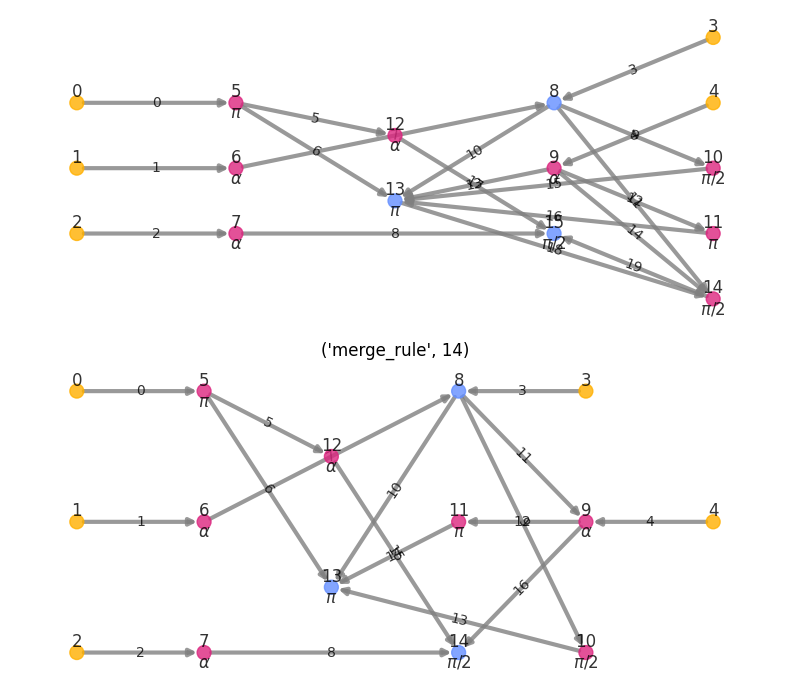

2024-04-25 13:39:14.766429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'observation_5' with dtype int32 and shape [1]
	 [[{{node observation_5}}]]
2024-04-25 13:39:14.766525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'observation_9' with dtype int32 and shape [1]
	 [[{{node observation_9}}]]


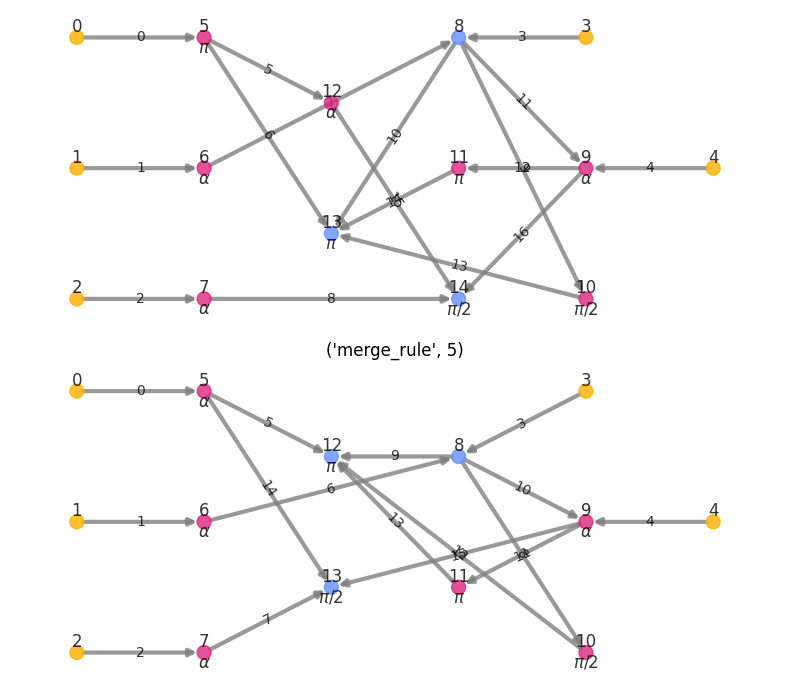

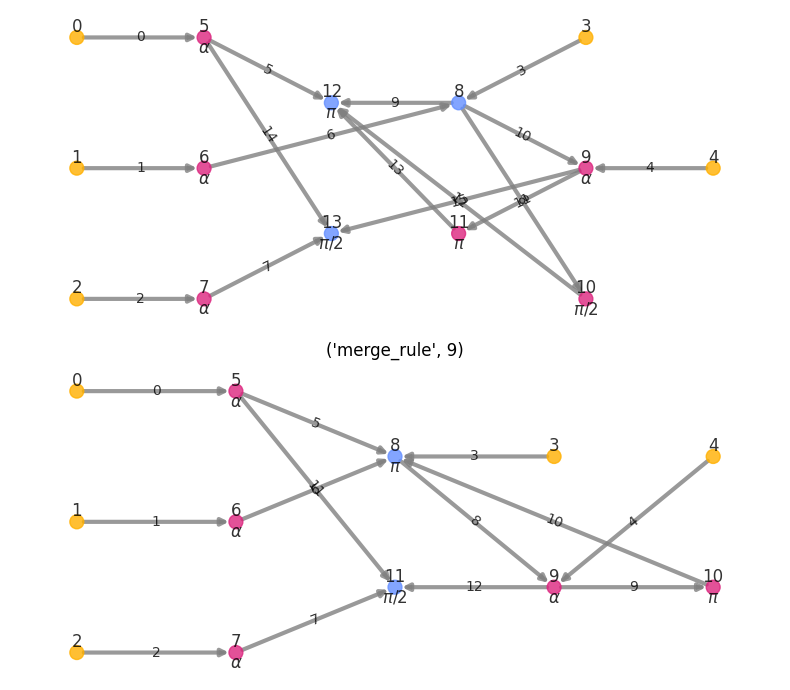

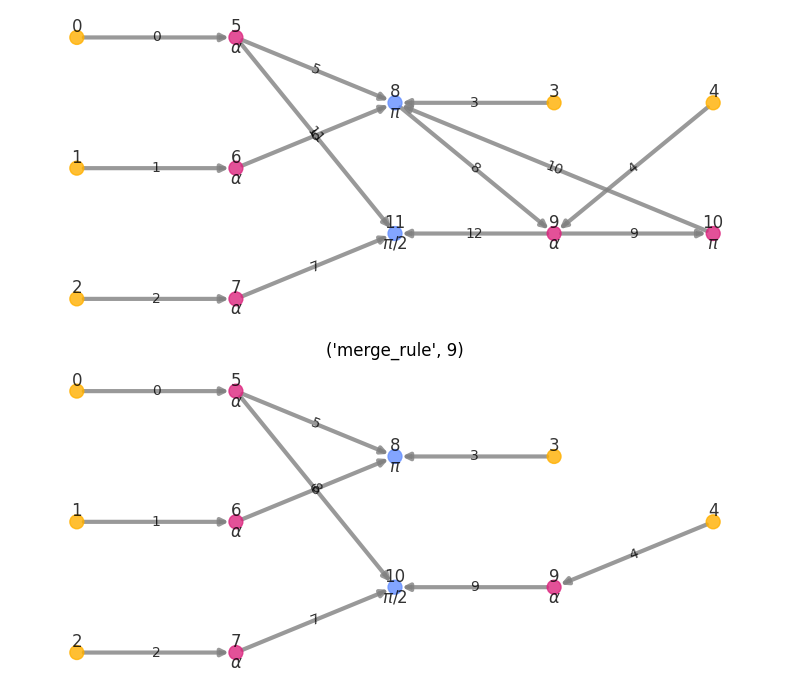

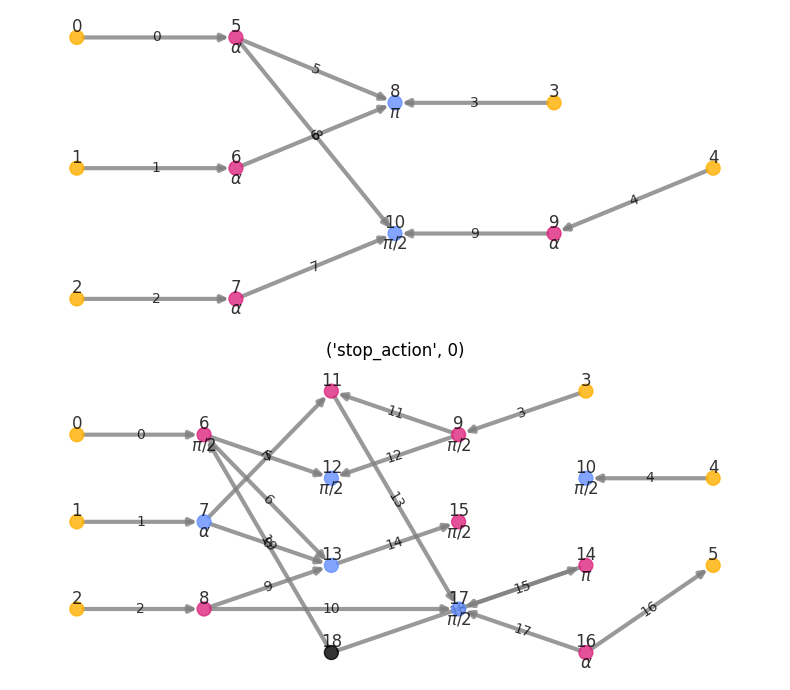

In [8]:
# Optimize for n_steps
n_steps = 5

observation, mask = env.reset()
observation = [observation]
mask = [mask]

for step in range(0, n_steps):

    # Batch graph observation to graph tensor and mask to tensor
    observation_batched = batch_obs_combined_traj(observation)
    mask_batched = batch_mask_combined(mask)
    # Get the logprobs, action
    action, logprobability_t  = ppo_agent.sample_action_logits_trajectory(observation_batched, mask_batched)
    # Take one step in the environment
    next_observation, next_mask, reward, next_done = env.step(action.numpy()[0])
    
    # Plot action
    plot_action(observation[0], next_observation, action.numpy()[0])
    
    observation = [next_observation]
    mask = [next_mask]
